In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
% matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Read Data

In [2]:
def readDataRuiJinAD(filePath):
    """AD VS Normal"""
    df = pd.read_csv(filePath)
    names = df.columns[1:]
    y = df['category']
    y = np.where(y == "AD", 0, y)
    y = np.where(y == "Normal", 1, y)
    y = y.astype('int')
    X = df.iloc[:, 1:].values
    scalar = MinMaxScaler((-1, 1))
    X = scalar.fit_transform(X)
    return X, y, names, df


path2pickle = '../dataset/sample_smile_result.pkl'
X, y, names, _ = readDataRuiJinAD('../dataset/sample_alzheimer_vs_normal_data.csv')
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forest

In [3]:
model_rf = RandomForestClassifier(random_state=0)

In [4]:
# parameter tuning
parameters = {'max_depth': [i for i in range(3, 15)],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [i * 50 for i in range(1, 3)]}

gs_rf = GridSearchCV(model_rf, parameters, n_jobs=-1, cv=5, scoring="f1")
gs_rf.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100]},
             scoring='f1')

In [5]:
rf_clf = gs_rf.best_estimator_
print(gs_rf.best_estimator_.get_params())
print(gs_rf.best_score_)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
1.0


In [6]:
rf_importance = pd.Series(rf_clf.feature_importances_, index=names).sort_values(ascending=False)

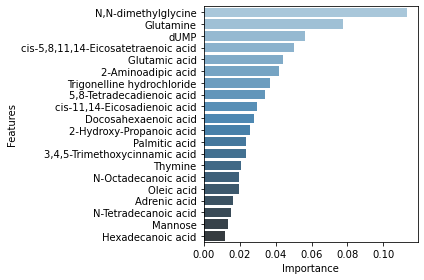

In [7]:
ax = sns.barplot(x=rf_importance[:20], y=rf_importance.index[:20], palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_rf.tif', dpi=300)
plt.show()

### SVM

In [8]:
# parameter tuning
from sklearn import svm

model_svm = svm.SVC(kernel='linear', random_state=0)

In [12]:
parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
gs_svm = GridSearchCV(model_svm, parameters, n_jobs=-1, cv=5, scoring="f1")
gs_svm.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=0), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='f1')

In [13]:
svm_clf = gs_svm.best_estimator_
print(gs_svm.best_estimator_.get_params())
print(gs_svm.best_score_)

{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
0.9658181818181818


In [14]:
svm_importance = pd.Series(abs(svm_clf.coef_[0]), index=names).nlargest(20)

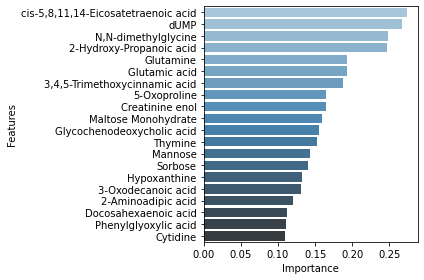

In [15]:
ax = sns.barplot(x=svm_importance.values, y=svm_importance.index, palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_svm_avg.tif', dpi=400)
plt.show()
